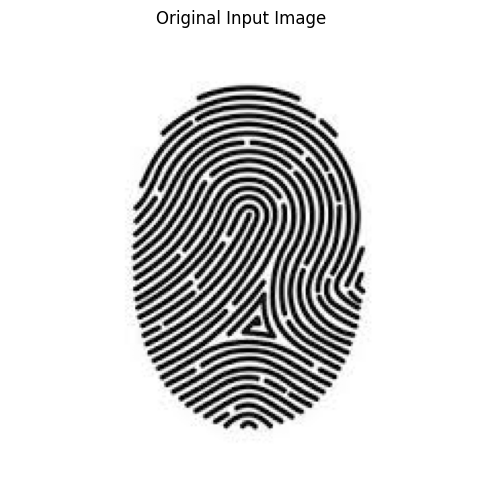

Displaying Decomposition Stages...


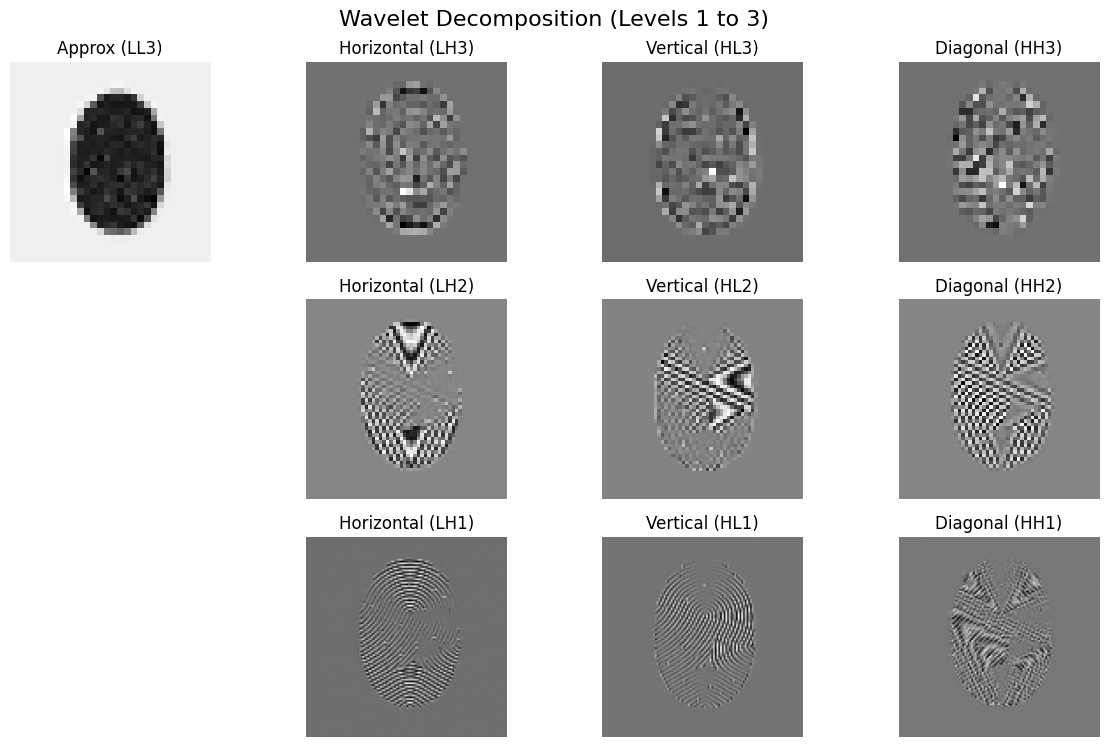


Extracting Features...
FINAL FEATURE VECTOR
                        0
LL3_Energy   2.942871e+09
LL3_Mean     1.742251e+03
LH3_Energy   2.961555e+06
LH3_Entropy  7.688442e+00
LH3_StdDev   5.736390e+01
HL3_Energy   3.509408e+06
HL3_Entropy  7.674420e+00
HL3_StdDev   6.244216e+01
HH3_Energy   3.553736e+06
HH3_Entropy  7.659752e+00
HH3_StdDev   6.278868e+01
LH2_Energy   3.662584e+07
LH2_Entropy  9.459522e+00
LH2_StdDev   1.043432e+02
HL2_Energy   2.977726e+07
HL2_Entropy  9.413710e+00
HL2_StdDev   9.407689e+01
HH2_Energy   3.056135e+07
HH2_Entropy  9.640562e+00
HH2_StdDev   9.531429e+01
LH1_Energy   2.413318e+07
LH1_Entropy  1.155302e+01
LH1_StdDev   4.309256e+01
HL1_Energy   2.037960e+07
HL1_Entropy  1.149838e+01
HL1_StdDev   3.959977e+01
HH1_Energy   4.575911e+06
HH1_Entropy  1.151148e+01
HH1_StdDev   1.876437e+01


In [7]:
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def load_image(path=None):
    """Loads an image or generates a synthetic one if path is None."""
    if path:
        # Load as Grayscale (0 flag is crucial for MRA)
        img = cv2.imread(path, 0)
        if img is None:
            raise ValueError(f"Could not load image at {path}")
    else:
        print("[INFO] No path provided. Generating synthetic image for demo...")
        img = np.zeros((512, 512), dtype=np.uint8)
        cv2.rectangle(img, (100, 100), (400, 400), 255, -1)
        cv2.circle(img, (256, 256), 100, 0, -1)
        # Add noise
        noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
        img = cv2.add(img, noise)
    
    return img

def visualize_decomposition(coeffs):
    """
    Plots the Approximations and Details for all levels.
    coeffs structure: [cAn, (cHn, cVn, cDn), ..., (cH1, cV1, cD1)]
    """
    level_count = len(coeffs) - 1
    
    # Create a figure
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"Wavelet Decomposition (Levels 1 to {level_count})", fontsize=16)

    # 1. Plot Approximation (Lowest Level)
    cA = coeffs[0]
    ax = fig.add_subplot(level_count + 1, 4, 1)
    ax.imshow(cA, cmap='gray')
    ax.set_title(f"Approx (LL{level_count})")
    ax.axis('off')

    # 2. Loop through details
    # coeffs[1] is Level n details, coeffs[2] is Level n-1...
    for i, details in enumerate(coeffs[1:]):
        level_index = level_count - i
        (cH, cV, cD) = details
        
        # Determine plot row (starts after approximation)
        row = i + 1 
        
        # Horizontal Details (LH)
        ax1 = fig.add_subplot(level_count + 1, 4, row * 4 - 2)
        ax1.imshow(cH, cmap='gray')
        ax1.set_title(f"Horizontal (LH{level_index})")
        ax1.axis('off')

        # Vertical Details (HL)
        ax2 = fig.add_subplot(level_count + 1, 4, row * 4 - 1)
        ax2.imshow(cV, cmap='gray')
        ax2.set_title(f"Vertical (HL{level_index})")
        ax2.axis('off')

        # Diagonal Details (HH)
        ax3 = fig.add_subplot(level_count + 1, 4, row * 4)
        ax3.imshow(cD, cmap='gray')
        ax3.set_title(f"Diagonal (HH{level_index})")
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

def extract_features(coeffs):
    """Extracts statistical features from the coefficients."""
    features = {}
    
    # Helper for Entropy
    def calc_entropy(matrix):
        p = np.abs(matrix.flatten())
        p = p / (np.sum(p) + 1e-10)
        p = p[p > 0]
        return -np.sum(p * np.log2(p))

    # Process Approximation
    cA = coeffs[0]
    level = len(coeffs) - 1
    features[f'LL{level}_Energy'] = np.sum(cA**2)
    features[f'LL{level}_Mean'] = np.mean(cA)
    
    # Process Details
    for i, (cH, cV, cD) in enumerate(coeffs[1:]):
        curr_lvl = level - i
        
        # Loop over the tuple of details
        for band, name in zip([cH, cV, cD], ['LH', 'HL', 'HH']):
            features[f'{name}{curr_lvl}_Energy'] = np.sum(band**2)
            features[f'{name}{curr_lvl}_Entropy'] = calc_entropy(band)
            features[f'{name}{curr_lvl}_StdDev'] = np.std(band)

    return pd.DataFrame([features]).T

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # ---------------------------------------------------------
    # REPLACE None WITH YOUR IMAGE PATH BELOW
    # Example: image_path = "C:/Users/Name/Desktop/my_mri.jpg"
    # ---------------------------------------------------------
    image_path = "finger print.jpg" # or "C:/Users/You/Desktop/image.png"
    
    try:
        # 1. Load Image
        original_img = load_image(image_path)
        
        # Show Original Image
        plt.figure(figsize=(6,6))
        plt.imshow(original_img, cmap='gray')
        plt.title("Original Input Image")
        plt.axis('off')
        plt.show()

        # 2. Perform Wavelet Decomposition (MRA)
        # 'haar' is blocky, 'db4' is smoother. Level 3 gives decent depth.
        coeffs = pywt.wavedec2(original_img, 'db2', level=3)

        # 3. VISUALIZE STAGES
        print("Displaying Decomposition Stages...")
        visualize_decomposition(coeffs)

        # 4. Extract and Print Features
        print("\nExtracting Features...")
        feats = extract_features(coeffs)
        print("="*40)
        print("FINAL FEATURE VECTOR")
        print("="*40)
        print(feats)
        
    except Exception as e:
        print(f"Error: {e}")